# uniCOX

In [1]:
setwd("E:/notebook/childhood_pneumonia")
library(dplyr)
library(survival)
library(plyr)
library(MASS)
library(forestplot)
library(pheatmap)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: grid

Loading required package: magrittr

Loading required package: checkmate



In [2]:
data<-read.csv("./Temps/1.finalData.csv",stringsAsFactors = F)
Cox_sx<-read.csv("./Results/1.dataBeforeCox.csv",stringsAsFactors = F)
head(Cox_sx,2)

,SUBJECT_ID,ADMI_AGE,GENDER,Time,EXPIRE_FLAG,X5013.PARAINFLUENZA.VIRUS.TYPE.2,X5015.RSV,X5205.HIV.Antibody,X5333.starch.granules,X5370.WBC.pus.cell,⋯,X5493.Basophils.Count,X5626.C.Reactive.Protein,X6236.Cholinesterase,X6261.Cystatin.C,X6316.Monocyte.Count,X6317.Monocytes,X6318.Eosinophil.Count,X6471.Serum.hemolytic.index,X6472.Serum..icteric.index,X6473.Lipase
,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,628,198,F,15,0,Negative,Negative,NA,Negative,Negative,⋯,0.03,NA,5381,0.62,0.14,1.9,0.01,19,1,8
2,643,48,F,17,0,Negative,Positive,NA,NA,NA,⋯,0.01,16,NA,NA,0.12,2.0,0.03,NA,NA,NA


In [3]:
UniCox_Data<-Cox_sx[,-c(1,4,5)]
UniCox_Data$GENDER<-as.factor(UniCox_Data$GENDER)
surv<-Surv(time = Cox_sx$Time,event = Cox_sx$EXPIRE_FLAG)
UniCox_Data$surv=surv

In [4]:
#unicox function
UniCox<-function(x){
  FML<-as.formula(paste0("surv~",x))
  Cox<-coxph(FML,data = UniCox_Data) 
  Sum<-summary(Cox)
  CI<-paste0(round(Sum$conf.int[,3:4],3),collapse = "-") 
  Pvalue<-round(Sum$coefficients[,5],3)
  HR<-round(Sum$coefficients[,2],3)
  Unicox<-data.frame("Characteristics"=x,
                     "Hazard Ratio"=HR,
                     "CI95"=CI,
                     "P value"=Pvalue)
  return(Unicox)
}

In [5]:
head(UniCox_Data,2)

,ADMI_AGE,GENDER,X5013.PARAINFLUENZA.VIRUS.TYPE.2,X5015.RSV,X5205.HIV.Antibody,X5333.starch.granules,X5370.WBC.pus.cell,X5371.mucus,X5378.Other.cells,X5379.RBC,⋯,X5626.C.Reactive.Protein,X6236.Cholinesterase,X6261.Cystatin.C,X6316.Monocyte.Count,X6317.Monocytes,X6318.Eosinophil.Count,X6471.Serum.hemolytic.index,X6472.Serum..icteric.index,X6473.Lipase,surv
,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<Surv>
1,198,F,Negative,Negative,NA,Negative,Negative,Negative,Negative,Negative,⋯,NA,5381,0.62,0.14,1.9,0.01,19,1,8,"15, 0"
2,48,F,Negative,Positive,NA,NA,NA,NA,NA,NA,⋯,16,NA,NA,0.12,2.0,0.03,NA,NA,NA,"17, 0"


In [6]:
varNames<-colnames(UniCox_Data)[1:87] 
length(varNames)
UniVar<-list()
for (nm in varNames){
  temp <- tryCatch(
    { UniCox(nm) },
    error = function(e) { message('Error @ ',nm) ; return(NA) },
    finally = { message('next...') 
    }
  )
  UniVar[[nm]] <- temp
}



[1] 87

next...

next...

Error @ X5013.PARAINFLUENZA.VIRUS.TYPE.2

next...

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  1,2 ; coefficient may be infinite. "
next...

Error @ X5205.HIV.Antibody

next...

next...

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  3,4 ; coefficient may be infinite. "
next...

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  1 ; coefficient may be infinite. "
next...

next...

Error @ X5379.RBC

next...

Error @ X5407.Blood

next...

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  2 ; coefficient may be infinite. "
next...

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  1,2,3,4,5,6,7 ; coefficient 

In [7]:
UniVar<-ldply(UniVar,data.frame)
UniVar<-UniVar[,2:5]
UniVar<-na.omit(UniVar)
#write.csv(UniVar,"./Results/2.unicoxResults.csv",row.names = F)


In [8]:
Cox_Item<-UniVar$Characteristics[UniVar$P.value<0.05]
Cox_data<-data[,c(which(colnames(data) %in% Cox_Item))]
Cox_data<-Cox_data %>%filter(!if_all(.fns = is.na))
p_id<-data$SUBJECT_ID[as.numeric(rownames(Cox_data))] 

In [9]:
Cox_all<-cbind(SUBJECT_ID=data$SUBJECT_ID, Time=data$Time, EXPIRE_FLAG=data$EXPIRE_FLAG)
Cox_all<-as.data.frame(Cox_all[which(Cox_all[,1]%in% p_id),]) 
heat_fac <- Cox_data %>% select_if(is.character)
heat_num <- Cox_data %>% select_if(is.numeric)
Cox_all<-cbind(Cox_all,heat_fac,heat_num)
table(Cox_all$EXPIRE_FLAG)
head(Cox_all,2)


  0   1 
536  95 

,SUBJECT_ID,Time,EXPIRE_FLAG,X5409.Hardness,X5002.Eosinophils,X5022.adenosine.deaminase,X5033.Urea,X5034.Calcium..Total,X5045.Gamma.Glutamyltransferase,X5055.Bilirubin..Indirect,⋯,X5224.Calculated.Bicarbonate..Whole.Blood,X5227.Lactate,X5237.pH,X5239.pO2,X5248.Bicarbonate,X5249.Base.Excess,X5252.Oxygen.Saturation,X6317.Monocytes,X6471.Serum.hemolytic.index,X6473.Lipase
,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,628,15,0,Pasty,0.1,52,5.13,2.09,308,3.9,⋯,23.9,1.4,7.280,51.9,22.3,-1.9,81.6,1.9,19,8
2,643,17,0,NA,0.6,NA,NA,NA,NA,NA,⋯,28.0,1.3,7.312,52.7,26.5,2.4,90.9,2.0,NA,NA


# mutiCOX

In [10]:
UniCox_var<-cbind( Time=Cox_all$Time, EXPIRE_FLAG=Cox_all$EXPIRE_FLAG,
                  X5409.Hardness=Cox_all[,4],
                   Cox_all[,c(5:27)])
UniCox_var<-na.omit(UniCox_var)
items<-colnames(UniCox_var)[-(1:2)]
s<-paste(items,collapse="+")
FML<-as.formula(paste0("Surv(Time, EXPIRE_FLAG)~",s))
res.cox <- coxph(FML, data = UniCox_var)
mucox<-summary(res.cox)
mucox

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  2 ; coefficient may be infinite. "


Call:
coxph(formula = FML, data = UniCox_var)

  n= 466, number of events= 57 

                                                coef  exp(coef)   se(coef)
X5409.HardnessSoft                         8.219e-01  2.275e+00  3.629e-01
X5409.HardnessThin                        -1.382e+01  9.972e-07  2.932e+03
X5002.Eosinophils                         -1.471e-01  8.632e-01  5.454e-01
X5022.adenosine.deaminase                 -1.668e-02  9.835e-01  1.047e-02
X5033.Urea                                -2.049e-01  8.147e-01  7.621e-02
X5034.Calcium..Total                      -8.389e-01  4.322e-01  5.879e-01
X5045.Gamma.Glutamyltransferase           -3.560e-03  9.964e-01  3.221e-03
X5055.Bilirubin..Indirect                  3.426e-03  1.003e+00  5.358e-03
X5083.Uric.Acid..Urine                     4.759e-03  1.005e+00  1.491e-03
X5095.Neutrophils..                        8.187e-02  1.085e+00  5.109e-01
X5099.Hemoglobin                          -2.047e-02  9.797e-01  9.224e-03
X5111.Lymphocytes..P

In [13]:
formatFit<-function(fit){
  p_val<-summary(fit)$coefficients[,5]
  wald<-summary(fit)$coefficients[,4]^2
  valueB<-summary(fit)$coefficients[,1]
  valueOR<-summary(fit)$coefficients[,2]
  confitOR<-exp(confint(fit))
  data.frame(
    OR_with_CI=paste(round(valueOR,3),"(",
                     round(confitOR[,1],3),"-",round(confitOR[,2],3),")",sep=""),
    P=round(p_val,3),
    coef=round(valueB,3),
    Wald=round(wald,3),
    exp.coef=round(valueOR,3),
    lower=round(confitOR[,1],3),
    upper=round(confitOR[,2],3)
  )
}
summary(res.cox)$coefficients
data_f=formatFit(res.cox)
write.csv(data_f,"./Temps/2. forestplot_muti.csv")#your need to add a title

,coef,exp(coef),se(coef),z,Pr(>|z|)
X5409.HardnessSoft,8.218527e-01,2.274710e+00,3.628704e-01,2.264865349,0.02352094
X5409.HardnessThin,-1.381833e+01,9.971837e-07,2.931949e+03,-0.004713019,0.99623957
X5002.Eosinophils,-1.470516e-01,8.632494e-01,5.453795e-01,-0.269631781,0.78744355
X5022.adenosine.deaminase,-1.668362e-02,9.834548e-01,1.047032e-02,-1.593420660,0.11106585
X5033.Urea,-2.049271e-01,8.147067e-01,7.621405e-02,-2.688836635,0.00717015
X5034.Calcium..Total,-8.389048e-01,4.321836e-01,5.878667e-01,-1.427032304,0.15357058
X5045.Gamma.Glutamyltransferase,-3.560192e-03,9.964461e-01,3.221310e-03,-1.105200268,0.26907282
X5055.Bilirubin..Indirect,3.425842e-03,1.003432e+00,5.358407e-03,0.639339688,0.52260198
X5083.Uric.Acid..Urine,4.758955e-03,1.004770e+00,1.490778e-03,3.192262488,0.00141163
X5095.Neutrophils..,8.186810e-02,1.085313e+00,5.108764e-01,0.160250301,0.87268391


png 
  2

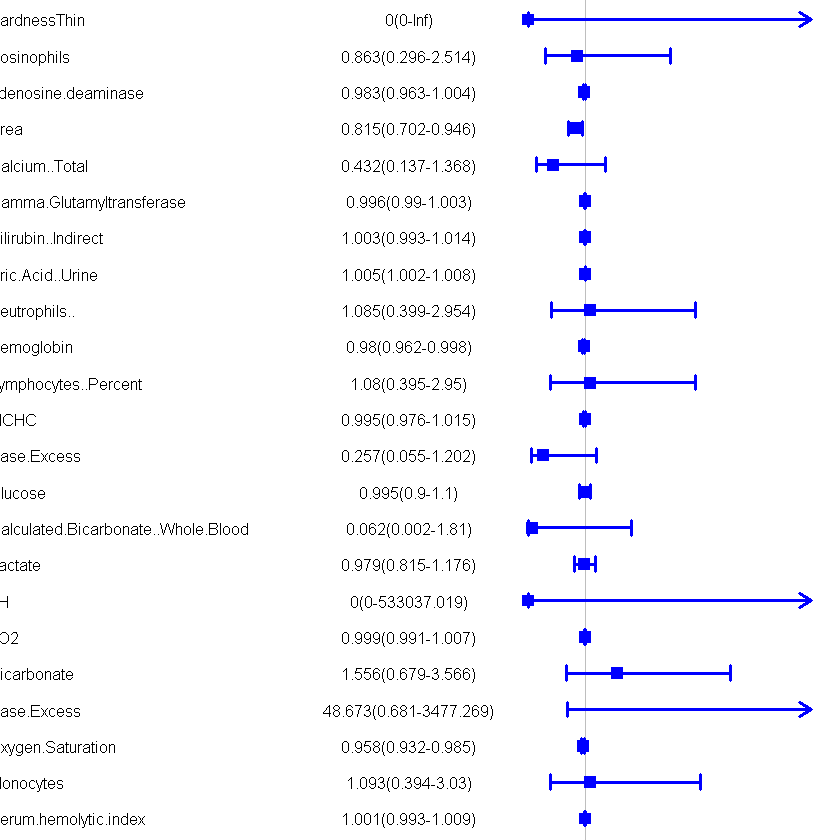

In [15]:
data=read.csv("./Temps/2. forestplot_muti.csv")
f<-forestplot(as.matrix(data[,c(1:3)]),data$exp.coef,data$lower,
           data$upper,zero = 1,xlog = F,
           clip = c(0,5),
           colgap = unit(5,"mm"),graphwidth=unit(60,"mm"),
           lineheight = unit(0.8,"cm"),graph.pos = 3,
           col = fpColors(box="blue", lines="blue", zero = "grey"),boxsize = 0.3,
           ci.vertices = T,ci.vertices.height = 0.2,
           lty.ci = 7,lwd.zero=0.4,lwd.ci = 3,
           txt_gp=fpTxtGp(label = gpar(cex=0.8),
                          ticks = gpar(cex=0.8)) ,
           is.summary=c(TRUE,rep(FALSE,100))
    )
f
pdf("./Figs/2. forestPlot.pdf",width=10, height=12)
f
dev.off()

In [12]:
#NA num
hardness<-length(which(is.na(Cox_all$X5409.Hardness)==T))
urea<-length(which(is.na(Cox_all$X5033.Urea)==T))
uricAcid<-length(which(is.na(Cox_all$X5083.Uric.Acid..Urine)==T)) 
hemoglobin<-length(which(is.na(Cox_all$X5099.Hemoglobin)==T)) 
oxygenSaturation<-length(which(is.na(Cox_all$X5252.Oxygen.Saturation)==T)) 
lipase<-length(which(is.na(Cox_all$X6473.Lipase)==T)) 
cat("hardness:",hardness,"; urea:",urea,"; uric Acid:",uricAcid,";\n hemoglobin:",hemoglobin,
    "; oxygenSaturation:",oxygenSaturation,"; lipase:",lipase)


hardness: 107 ; urea: 11 ; uric Acid: 13 ;
 hemoglobin: 10 ; oxygenSaturation: 3 ; lipase: 13

In [13]:
mucox_items<-names(which(mucox$coefficients[,5]<0.05) )
mucox_data<-Cox_all[,which(colnames(Cox_all)%in%mucox_items)]
mucox_data<-cbind(survival=Cox_all$EXPIRE_FLAG,Time=Cox_all$Time,mucox_data)
mucox_data$X5099.Hemoglobin[which(mucox_data$X5099.Hemoglobin==0)]<-NA #erro num change to NA
head(mucox_data,2)
#write.csv(mucox_data,"./Results/2.model_data.csv",row.names = F)

,survival,Time,X5033.Urea,X5083.Uric.Acid..Urine,X5099.Hemoglobin,X5252.Oxygen.Saturation,X6473.Lipase
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,0,15,5.13,460,91,81.6,8
2,0,17,NA,NA,NA,90.9,NA


## heatmap

 Survival  Hardness  
 0:409    Pasty:394  
 1: 57    Soft : 69  
          Thin :  3  

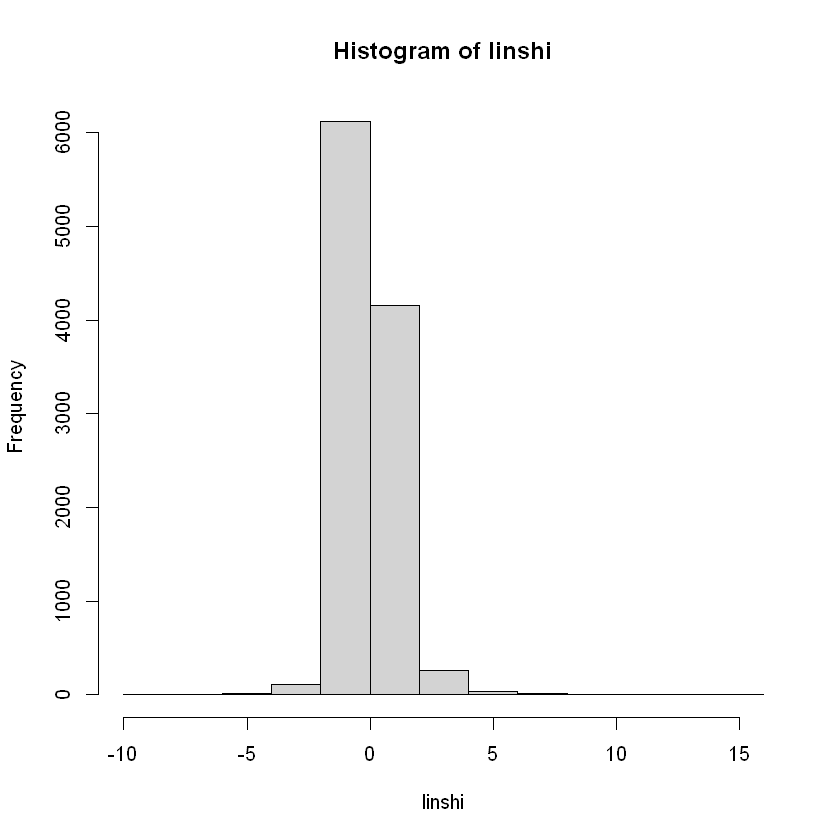

In [10]:
Cox_all<-na.omit(Cox_all)
Cox_all<-Cox_all[order(Cox_all$EXPIRE_FLAG),]
heat_cli=Cox_all[,3:4]#factor
heat_exp=Cox_all[,5:27]#num
annotation_col = data.frame(Survival=as.factor(heat_cli[,1]),
                            Hardness = as.factor(heat_cli[,2]))
summary(annotation_col)
rownames(annotation_col) <- Cox_all$SUBJECT_ID
ann_colors = list(
  Survival=c("0"="#2E94B9","1"="#de4307"),
  Hardness = c( "Pasty"="#A6CEE3" ,"Soft"="#1F78B4","Thin"="#B2DF8A"))
red <- rgb(255,0,0,maxColorValue = 255)
blue <- rgb(0,0,255,maxColorValue = 255)
white <- rgb(255,255,255,maxColorValue = 255)
linshi <- scale(heat_exp[,1:23])
rownames(linshi) <- Cox_all$SUBJECT_ID
linshi<-t(linshi)
hist(linshi)


png 
  2

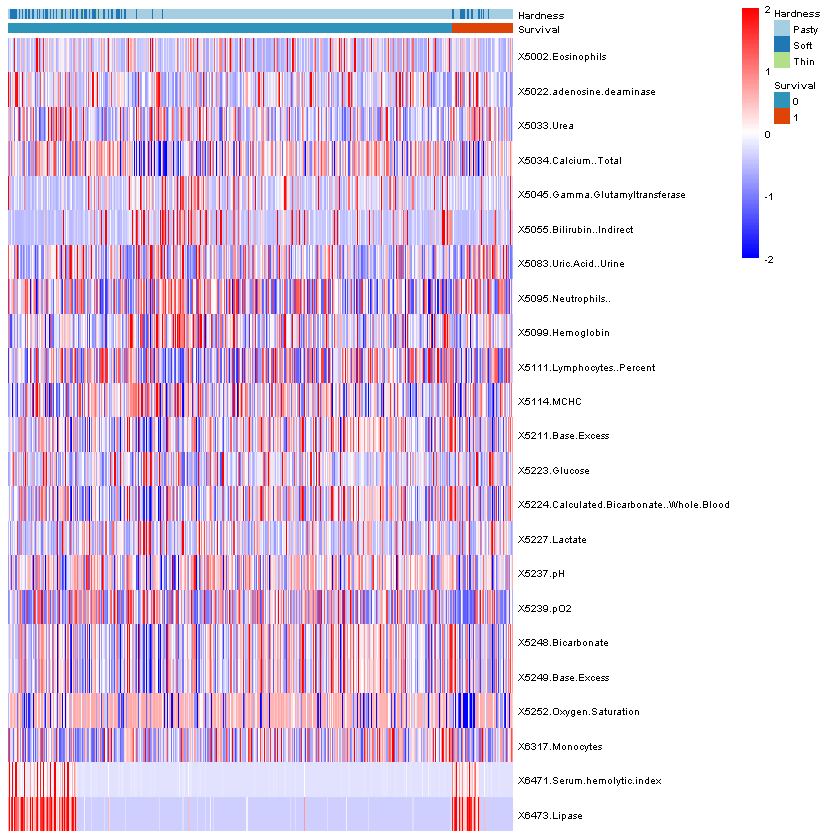

In [12]:
linshi[linshi>2] <- 2
linshi[linshi<(-2)] <- c(-2)
p<-pheatmap(linshi,fontsize=6,cutree_col = 4,#cellheight = 2,cellwidth = 1 ,
         color  = colorRampPalette(c(blue,white,red))(100),
         annotation_col = annotation_col,
         annotation_colors = ann_colors,
         clustering_method = "ward.D2",
         border_color = "grey60",
         cluster_cols = F, cluster_rows = F,
         show_rownames = T, show_colnames = F
    )
p
pdf("./Figs/2. heatmap.pdf")
p
dev.off()